# Assignment: Housing Prices Prediction

## 1. Introduction
---


#### 1.1. Problem Statement

A US-based housing company named Surprise Housing has decided to enter the Australian market. The company uses data analytics to purchase houses at a price below their actual values and flip them on at a higher price. For the same purpose, the company has collected a data set from the sale of houses in Australia. The data is provided in the CSV file below.

The company is looking at prospective properties to buy to enter the market. You are required to build a regression model using regularisation in order to predict the actual value of the prospective properties and decide whether to invest in them or not.

The company wants to know:
- Which variables are significant in predicting the price of a house, and
- How well those variables describe the price of a house.

#### 1.2. Business Goal

The goal is to model the price of houses with the available independent variables. This model will then be used by the management to understand how exactly the prices vary with the variables. They can accordingly manipulate the strategy of the firm and concentrate on areas that will yield high returns. Further, the model will be a good way for management to understand the pricing dynamics of a new market.

#### 1.3. Approach

Since the price of a house is a continuous variable, this is a regression problem. The analysis will be conducted in the following steps:

- Data cleaning and removal of unnecessary features
- Exploratory data analysis and visualization
- Data preprocessing and feature selection
- Fitting a regression model on the data
- Calculating the feature importances
- Conclusion


## 2. Data Ingestion
---

In [1]:
import numpy as np, pandas as pd
from warnings import filterwarnings
filterwarnings('ignore')

df = pd.read_csv('train.csv')
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [2]:
df.shape

(1460, 81)

## 3. Data Cleaning
---

#### 3.1. Treating NULLs



First, we dive into the dataset to flag columns with a lot of NULL values, because they do not really add anything useful to our analysis. With the amount of data we have, it is smart to keep a tight grip on the number of NULLs we allow. Being too lenient would mean more columns filled with NULLs than we would want, compared to the total rows we are dealing with.

In [3]:
df.loc[:, df.columns[(df.isnull().sum() / df.shape[0]) > 0]].isnull().sum().sort_values(ascending = False)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
Electrical         1
dtype: int64

We can straightaway remove the features with more than 1000 NULLs since they almost completely consume the length of the dataset.

In [4]:
df.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence'], axis = 1, inplace = True)
df.loc[:, df.columns[(df.isnull().sum() / df.shape[0]) > 0]].isnull().sum().sort_values(ascending = False)

MasVnrType      872
FireplaceQu     690
LotFrontage     259
GarageType       81
GarageYrBlt      81
GarageFinish     81
GarageQual       81
GarageCond       81
BsmtExposure     38
BsmtFinType2     38
BsmtQual         37
BsmtCond         37
BsmtFinType1     37
MasVnrArea        8
Electrical        1
dtype: int64

As per the data dictionary, many of these columns have an NA category. We may want to impute the missing values for those columns as NA, since NA itself implies the lack of that feature. For `Electrical`, since there is only one NULL, we can drop that row.

For the basement features `BsmtExposure`, `BsmtQual` and `BsmtCond`, `BsmtFinType1` and `BsmtFinType2`, `TotalBsmtSF` being 0 would confirm the lack of a basement and we can safely assign the features as "NA". This would take care of many of the NULLs which are actually due to lack of a basement area and also anomalies where area is zero but the related features are not NA.

Similarly, if `Fireplaces` = 0, then we can assign `FireplaceQu` as NA for those houses.

Similarly, if `GarageArea` = 0, then the remaining garage features can be safely assigned as NA.

In [5]:
df = df.loc[~df['Electrical'].isna(), ]
df.loc[df['TotalBsmtSF'] == 0, ['BsmtExposure', 'BsmtQual', 'BsmtCond', 'BsmtFinType1', 'BsmtFinType2']] = 'NA'
df.loc[df['GarageArea'] == 0, ['GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond']] = 'NA'
df.loc[df['Fireplaces'] == 0, 'FireplaceQu'] = 'NA'
df.loc[:, df.columns[(df.isnull().sum() / df.shape[0]) > 0]].isnull().sum().sort_values(ascending = False)

MasVnrType      871
LotFrontage     259
MasVnrArea        8
BsmtExposure      1
BsmtFinType2      1
dtype: int64

`MasVnrArea` can be imputed with 0 in case of NULLs since there are only 8 missing values. Consequently, we can assign `MasVnrType` as "None" for those houses.

We can drop the houses with NULL `BsmtExposure` and `BsmtFinType2` at this point.

`BsmtFinType1` and `BsmtFinType2` are ratings of Basement Finished area, which would depend on how much of the basement area is finished. Ideally, if we have `BsmtUnfSF` as non-zero, then the ratings would be "Unf", indicating "unfinished".

In [6]:
df = df.loc[~df['BsmtFinType2'].isna(), ]
df = df.loc[~df['BsmtExposure'].isna(), ]
df['MasVnrArea'] = df['MasVnrArea'].fillna(0)
df.loc[df['MasVnrArea'] == 0, 'MasVnrType'] = 'None'

df.loc[:, df.columns[(df.isnull().sum() / df.shape[0]) > 0]].isnull().sum().sort_values(ascending = False)

LotFrontage    259
MasVnrType       5
dtype: int64

Finally, we impute the `LotFrontage` feature by the global median.

In [7]:
m = df['LotFrontage'].median()
df['LotFrontage'] = df['LotFrontage'].fillna(m)
df.loc[:, df.columns[(df.isnull().sum() / df.shape[0]) > 0]].isnull().sum().sort_values(ascending = False)

MasVnrType    5
dtype: int64

**Note:**

In this section, the areas of basement, garage, masonry or number of fireplaces being 0 implied that there was no basement or garage or masonry or fireplace. However, we cannot assume the converse to be true because it is possible for a house to not have a basement or garage or masonry or a fireplace but still have allocated area for future construction.

#### 3.2. Removing unnecessary columns

Here we remove the columns that indicate some sort of ID, since they are identifiers and do not contribute to the analysis. We also remove the columns that have exactly 1 value, if they exist.

In [8]:
df.drop('Id', axis = 1, inplace = True)

In [9]:
[col for col in df.columns if df[col].nunique() == 1]

[]

## 4. Data Preprocessing
---

#### 4.1. Deriving Metrics

There are 4 year columns, i.e. `YearBuilt`, `YearRemodAdd`, `GarageYrBlt` and `YrSold`. Year values themselves are not of much use, but we can surely calculate things such as the age of the house at the time of selling, the number of years since the last remodel, number of years since garage was built, etc.

Here we shall create 4 new derived metrics:
- `YrsAtSale` which indicates age of the house at the time of sale
- `YrSinceRemod` which indicates how many years have passed since the last renovation at the time of sale
- `GarageAge` which indicates the age of the garage. If it has not been built, it would be 0.

In [10]:
df['YrsAtSale'] = df['YrSold'] - df['YearBuilt']
df['YrSinceRemod'] = df['YrSold'] - df['YearRemodAdd']
df['GarageAge'] = df.apply(lambda row: row['YrSold'] - int(row['GarageYrBlt']) if row['GarageYrBlt'] != 'NA' else 0, axis = 1)

## Dropping the year variables now
df.drop(['YrSold', 'GarageYrBlt', 'YearRemodAdd', 'YearBuilt'], axis = 1, inplace = True)

#### 4.2. Categorical Variables

Here we shall create dummies out of the categorical variables.

In [11]:
cat_vars = [
    'MSSubClass',
    'MSZoning',
    'Street',
    'LandContour',
    'LotConfig',
    'Neighborhood',
    'Condition1',
    'Condition2',
    'BldgType',
    'HouseStyle',
    'RoofStyle',
    'RoofMatl',
    'Exterior1st',
    'Exterior2nd',
    'MasVnrType',
    'Foundation',
    'Heating',
    'CentralAir',
    'Electrical',
    'GarageType',
    'SaleType',
    'SaleCondition'
]

num_vars = [c for c in df.columns if c not in cat_vars]

for var in cat_vars:
    dummies = pd.get_dummies(df[var], prefix = var, drop_first = True).astype(int)
    df = pd.concat([df, dummies], axis = 1)
    df.drop(var, axis = 1, inplace = True)

#### 4.3. Ordinal Variables

Now we shall encode the ordinal variables into numeric such that their ordering is maintained. Note that the variables `OverallQual` and `OverallQual` are already ordinal and numeric.

In [12]:
lotshape = {
    'IR3': 0,
    'IR2': 1,
    'IR1': 2,
    'Reg': 3
}

utilities = {
    'ELO': 0,
    'NoSeWa': 1,
    'NoSewr': 2,
    'AllPub': 3
}

landslope = {
    'Sev': 0,
    'Mod': 1,
    'Gtl': 2
}

qual1 = {
    'Po': 0,
    'Fa': 1,
    'TA': 2,
    'Gd': 3,
    'Ex': 4
}

qual2= {
    'NA': 0,
    'Po': 1,
    'Fa': 2,
    'TA': 3,
    'Gd': 4,
    'Ex': 5
}

bsmtexposure = {
    'NA': 0,
    'No': 1,
    'Mn': 2,
    'Av': 3,
    'Gd': 4
}

bsmtfintype = {
    'NA': 0,
    'Unf': 1,
    'LwQ': 2,
    'Rec': 3,
    'BLQ': 4,
    'ALQ': 5,
    'GLQ': 6
}

functional = {
    'Sal': 0,
    'Sev': 1,
    'Maj2': 2,
    'Maj1': 3,
    'Mod': 4,
    'Min2': 5,
    'Min1': 6,
    'Typ': 7
}

garagefinish = {
    'NA': 0,
    'Unf': 1,
    'RFn': 2,
    'Fin': 3
}

paveddrive = {
    'N': 0,
    'P': 1,
    'Y': 2
}

df['LotShape'] = df['LotShape'].apply(lambda x: lotshape[x])
df['Utilities'] = df['Utilities'].apply(lambda x: utilities[x])
df['LandSlope'] = df['LandSlope'].apply(lambda x: landslope[x])
df['ExterQual'] = df['ExterQual'].apply(lambda x: qual1[x])
df['ExterCond'] = df['ExterCond'].apply(lambda x: qual1[x])
df['BsmtQual'] = df['BsmtQual'].apply(lambda x: qual2[x])
df['BsmtCond'] = df['BsmtCond'].apply(lambda x: qual2[x])
df['BsmtExposure'] = df['BsmtExposure'].apply(lambda x: bsmtexposure[x])
df['BsmtFinType1'] = df['BsmtFinType1'].apply(lambda x: bsmtfintype[x])
df['BsmtFinType2'] = df['BsmtFinType2'].apply(lambda x: bsmtfintype[x])
df['HeatingQC'] = df['HeatingQC'].apply(lambda x: qual1[x])
df['KitchenQual'] = df['KitchenQual'].apply(lambda x: qual1[x])
df['Functional'] = df['Functional'].apply(lambda x: functional[x])
df['FireplaceQu'] = df['FireplaceQu'].apply(lambda x: qual2[x])
df['GarageFinish'] = df['GarageFinish'].apply(lambda x: garagefinish[x])
df['GarageQual'] = df['GarageQual'].apply(lambda x: qual2[x])
df['GarageCond'] = df['GarageCond'].apply(lambda x: qual2[x])
df['PavedDrive'] = df['PavedDrive'].apply(lambda x: paveddrive[x])

In [13]:
df.shape

(1457, 207)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1457 entries, 0 to 1459
Columns: 207 entries, LotFrontage to SaleCondition_Partial
dtypes: float64(2), int64(205)
memory usage: 2.3 MB


#### 4.4. Feature Selection

In [15]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size = 0.2, random_state = 42)

sc = MinMaxScaler()
df_train.loc[:, num_vars] = sc.fit_transform(df_train.loc[:, num_vars])
df_test.loc[:, num_vars] = sc.transform(df_test.loc[:, num_vars])

y_train = df_train.pop('SalePrice')
y_test = df_test.pop('SalePrice')

In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

lr = LinearRegression()
lr.fit(df_train, y_train)
y_pred_train_initial = lr.predict(df_train)
y_pred_test_initial = lr.predict(df_test)

print('----- Training Set Metrics -----')
print(f'R-squared = {r2_score(y_train, y_pred_train_initial)}')
print(f'MAE = {mean_absolute_error(y_train, y_pred_train_initial)}')
print(f'RMSE = {np.sqrt(mean_squared_error(y_train, y_pred_train_initial))}')

print('\n----- Test Set Metrics -----')
print(f'R-squared = {r2_score(y_test, y_pred_test_initial)}')
print(f'MAE = {mean_absolute_error(y_test, y_pred_test_initial)}')
print(f'RMSE = {np.sqrt(mean_squared_error(y_test, y_pred_test_initial))}')

----- Training Set Metrics -----
R-squared = 0.9199848526895386
MAE = 0.0209363214513882
RMSE = 0.030925774899402854

----- Test Set Metrics -----
R-squared = -3196149706696.677
MAE = 15707.634101491862
RMSE = 204047.17690941514


By fitting a linear regression model on the current training set, we can see that there is very high overfitting. This can be due to a number of reasons, but the most likely reasons are we have too many features and possibly high multicollinearity.

We shall use manual backward elimination to keep the features that are likely to impact the sale price with a 95% confidence and remove the rest. We shall combine this with checking for features with VIF score more than 5, to eliminate multicollinearity.

In the code below, we are first checking for most insignificant feature and whether it is more than the critical value of 0.05. If yes, we eliminate the feature. If we are unable to find any such feature, we check the VIF scores of each feature and get the feature with the highest VIF score. If the score is more than 5, we eliminate the feature. Then repeat from beginning.

By the time the loop finishes, we will not only be left with features with p-value < 0.05 (significant), but also all of their VIF scores will be < 5, i.e. no multicollinearity.

In [17]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

while True:
    df_train_ols = sm.add_constant(df_train)
    ols = sm.OLS(y_train, df_train_ols)
    results = ols.fit()
    max_p = results.pvalues.max()
    max_p_feature = results.pvalues.index[results.pvalues.argmax()]
    vifs = [(col, variance_inflation_factor(df_train, i)) for i, col in enumerate(df_train.columns)]
    max_vif_feature, max_vif_val = max(vifs, key = lambda x: x[1])

    if max_p_feature != 'const' and max_p > 0.05:
        print(f'Removing {max_p_feature}, p-value = {max_p}')
        df_train.drop(max_p_feature, axis = 1, inplace = True)

    elif max_vif_val > 5:
        print(f'Removing {max_vif_feature}, VIF = {max_vif_val}')
        df_train.drop(max_vif_feature, axis = 1, inplace = True)

    else:
        break

Removing GarageQual, p-value = 0.9958103850116169
Removing Electrical_Mix, p-value = 0.9949150612206092
Removing Condition1_RRNn, p-value = 0.9913552436365662
Removing MSSubClass_75, p-value = 0.9837349096032493
Removing BsmtUnfSF, p-value = 0.981324190365111
Removing Electrical_FuseF, p-value = 0.9788985126070304
Removing Condition1_PosA, p-value = 0.9748701880036219
Removing RoofStyle_Gable, p-value = 0.973721063781595
Removing Exterior2nd_MetalSd, p-value = 0.970009410308394
Removing Neighborhood_BrDale, p-value = 0.9462496434894931
Removing CentralAir_Y, p-value = 0.9233929491461805
Removing HouseStyle_2Story, p-value = 0.923697916441969
Removing Condition2_RRAn, p-value = 0.9076089448798123
Removing LotConfig_Inside, p-value = 0.9054692862213505
Removing BsmtFinSF2, p-value = 0.8953308597851938
Removing EnclosedPorch, p-value = 0.8908285451057958
Removing SaleCondition_Alloca, p-value = 0.8795921560972689
Removing Condition2_PosA, p-value = 0.9722123544629204
Removing Exterior1st_

Now just to confirm the results, we shall fit another OLS model on the final list of features and verify the summary.

In [18]:
df_train_ols = sm.add_constant(df_train)
ols = sm.OLS(y_train, df_train_ols)
results = ols.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.755
Model:                            OLS   Adj. R-squared:                  0.751
Method:                 Least Squares   F-statistic:                     185.4
Date:                Tue, 20 Feb 2024   Prob (F-statistic):               0.00
Time:                        05:22:11   Log-Likelihood:                 1744.1
No. Observations:                1165   AIC:                            -3448.
Df Residuals:                    1145   BIC:                            -3347.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.0948      0.008     12.422      0.000       0.080       0.110
MasVnrArea                0.0866      0.013      6.515      0.000       0.061       0.113
BsmtExposure              0.0608      0.007      8.590      0.000       0.047       0.075
BsmtFinSF1                0.1425      0.023      6.222      0.000       0.098       0.187
2ndFlrSF                  0.2312      0.014     16.459      0.000       0.204       0.259
Fireplaces                0.0845      0.008     10.112      0.000       0.068       0.101
YrsAtSale                -0.1220      0.009    -13.889      0.000      -0.139      -0.105
MSSubClass_120           -0.0321      0.007     -4.336      0.000      -0.047      -0.018
MSSubClass_160           -0.0655      0.008     -7.731      0.000      -0.082      -0.049
LotConfig_CulDSac         0.0236      0.007      3.417      0.001       0.010       0.037
Neighborhood_NoRidge      0.0880      0.011      7.936      0.000       0.066       0.110
Neighborhood_NridgHt      0.1077      0.008     13.102      0.000       0.092       0.124
Neighborhood_StoneBr      0.1180      0.013      9.195      0.000       0.093       0.143
Condition2_PosN          -0.2065      0.041     -5.071      0.000      -0.286      -0.127
HouseStyle_1Story         0.0492      0.006      8.484      0.000       0.038       0.061
RoofMatl_WdShngl          0.2191      0.025      8.773      0.000       0.170       0.268
Exterior1st_BrkFace       0.0503      0.009      5.621      0.000       0.033       0.068
Exterior2nd_CmentBd       0.0546      0.009      5.891      0.000       0.036       0.073
Exterior2nd_ImStucc       0.0657      0.019      3.518      0.000       0.029       0.102
SaleCondition_Partial     0.0512      0.006      7.975      0.000       0.039       0.064
==============================================================================
Omnibus:                      185.238   Durbin-Watson:                   2.018
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2056.473
Skew:                           0.340   Prob(JB):                         0.00
Kurtosis:                       9.473   Cond. No.                         32.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [19]:
df_train.shape

(1165, 19)

We are left with 20 predictors (excluding the constant), all being statistically significant with 95% confidence and there is no multicollinearity. The R-squared and adjusted R-squared scores are 76% and 75% respectively.

## 5. Data Modelling
---

#### 5.1. Linear Regression

First we shall try and predict a vanilla Linear Regression model to see how it performs on the test set.

In [20]:
df_test = df_test[df_train.columns]

lr = LinearRegression()
lr.fit(df_train, y_train)
y_pred_vanilla = lr.predict(df_test)

print(f'R-squared for vanilla LR = {r2_score(y_test, y_pred_vanilla)}')
print(f'MAE for vanilla LR = {mean_absolute_error(y_test, y_pred_vanilla)}')
print(f'RMSE for vanilla LR = {np.sqrt(mean_squared_error(y_test, y_pred_vanilla))}')

R-squared for vanilla LR = 0.7362271454204187
MAE for vanilla LR = 0.043572978257412354
RMSE for vanilla LR = 0.058618146703953454


We had seen a r-squared score of 76% on the training set and now we are seeing a 74% r-squared score on the test set. This means the vanilla model is generalizing well. Let us try to use regularization to see if we can get better fits.

#### 5.2. Ridge Regression

We shall now fit a ridge regression model and use Grid Search to determine the lambda that enables the best fit.

In [21]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

ridge = Ridge(random_state = 42)
params = {'alpha': np.arange(0, 10, 0.001)}

gs_ridge = GridSearchCV(
    ridge,
    param_grid = params
)

gs_ridge.fit(df_train, y_train)

GridSearchCV(estimator=Ridge(random_state=42),
             param_grid={'alpha': array([0.000e+00, 1.000e-03, 2.000e-03, ..., 9.997e+00, 9.998e+00,
       9.999e+00])})

In [22]:
print(gs_ridge.best_score_)
print(gs_ridge.best_params_)

0.714643648214688
{'alpha': 1.2730000000000001}


In [23]:
y_pred_train_ridge = gs_ridge.predict(df_train)

print(f'R-squared for Ridge on training set = {r2_score(y_train, y_pred_train_ridge)}')
print(f'MAE for Ridge on training set = {mean_absolute_error(y_train, y_pred_train_ridge)}')
print(f'RMSE for Ridge on training set = {np.sqrt(mean_squared_error(y_train, y_pred_train_ridge))}')

R-squared for Ridge on training set = 0.7523344482719277
MAE for Ridge on training set = 0.038711876390610814
RMSE for Ridge on training set = 0.05440856701795551


In [31]:
y_pred_test_ridge = gs_ridge.predict(df_test)

print(f'R-squared for Ridge on test set = {r2_score(y_test, y_pred_test_ridge)}')
print(f'MAE for Ridge on test set = {mean_absolute_error(y_test, y_pred_test_ridge)}')
print(f'RMSE for Ridge on test set = {np.sqrt(mean_squared_error(y_test, y_pred_test_ridge))}')

R-squared for Ridge on test set = 0.7374566221699376
MAE for Ridge on test set = 0.04328158052251109
RMSE for Ridge on test set = 0.0584813740512279


Ridge regression with lambda of 1.273 results in a very small improvement in the scores on the test set from those produced by the vanilla model.

#### 5.3. Lasso Regression

In [25]:
from sklearn.linear_model import Lasso

lasso = Lasso(random_state = 42)

gs_lasso = GridSearchCV(
    lasso,
    param_grid = params
)

gs_lasso.fit(df_train, y_train)

GridSearchCV(estimator=Lasso(random_state=42),
             param_grid={'alpha': array([0.000e+00, 1.000e-03, 2.000e-03, ..., 9.997e+00, 9.998e+00,
       9.999e+00])})

In [26]:
print(gs_lasso.best_score_)
print(gs_lasso.best_params_)

0.7077013623797915
{'alpha': 0.0}


In [29]:
y_pred_train_lasso = gs_lasso.predict(df_train)

print(f'R-squared for Lasso on training set = {r2_score(y_train, y_pred_train_lasso)}')
print(f'MAE for Lasso on training set = {mean_absolute_error(y_train, y_pred_train_lasso)}')
print(f'RMSE for Lasso on training set = {np.sqrt(mean_squared_error(y_train, y_pred_train_lasso))}')

R-squared for Lasso on training set = 0.7547059821190911
MAE for Lasso on training set = 0.0388122941865651
RMSE for Lasso on training set = 0.05414744444224741


In [32]:
y_pred_test_lasso = gs_lasso.predict(df_test)

print(f'R-squared for Lasso on test set = {r2_score(y_test, y_pred_test_lasso)}')
print(f'MAE for Lasso on test set = {mean_absolute_error(y_test, y_pred_test_lasso)}')
print(f'RMSE for Lasso on test set = {np.sqrt(mean_squared_error(y_test, y_pred_test_lasso))}')

R-squared for Lasso on test set = 0.7362271454204186
MAE for Lasso on test set = 0.04357297825741238
RMSE for Lasso on test set = 0.05861814670395346


We can see that L1 regularization is not able to improve on the results produced by the vanilla model. Ridge has a slightly better performance. This indicates that the overfitting seen initially was primarily due to the excess number of features and multicollinearity. Since we had already addressed that before fitting the model, regularization did very little to improve the existing setup.

Nonetheless, we shall proceed with the Ridge model as our final model with lambda of 1.273.

## 6. Residual Analysis
---

After finalizing the model we shall now test its reliability through a residual analysis. In particular, we shall test:

- Whether the residuals are unbiased and homoscedastic with respect to the response.
- Whether the rresidual distribution is close to normal or approximately normal.

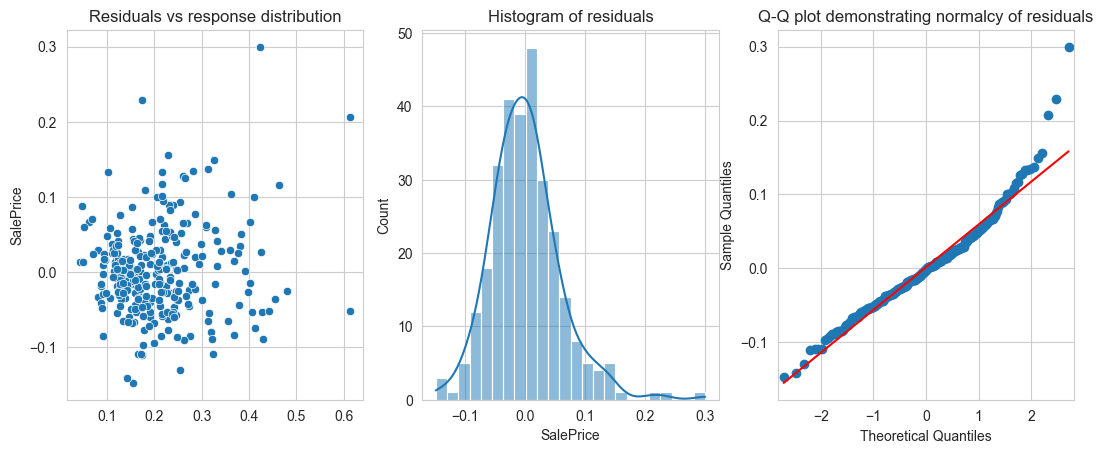

In [45]:
res = y_test - y_pred_test_ridge

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

fig, ax = plt.subplots(1, 3);
fig.set_figwidth(13)

sns.scatterplot(x = y_pred_test_ridge, y = res, ax = ax[0]);
ax[0].set_title('Residuals vs response distribution');

sns.histplot(res, kde = True, ax = ax[1]);
ax[1].set_title('Histogram of residuals');

sm.qqplot(res, ax = ax[2], line = 'r');
ax[2].set_title('Q-Q plot demonstrating normalcy of residuals');

The residuals do not appear to violate the assumptions of unbiasedness, homoscedasticity or normalcy. This implies that our model is reliable.

## 7. Feature Importance & Conclusion
---

Once our model is finalized and tested, we shall now conclude the analysis by providing the following:
- List of significant features
- Feature coefficients, i.e. how well they influence the normalized sale price of a house

Since we initially eliminated all features with more than 5% statistical insignificance, all features of the current training/test sets are therefore statistically significant.

In [47]:
df_train.columns.tolist()

['MasVnrArea',
 'BsmtExposure',
 'BsmtFinSF1',
 '2ndFlrSF',
 'Fireplaces',
 'YrsAtSale',
 'MSSubClass_120',
 'MSSubClass_160',
 'LotConfig_CulDSac',
 'Neighborhood_NoRidge',
 'Neighborhood_NridgHt',
 'Neighborhood_StoneBr',
 'Condition2_PosN',
 'HouseStyle_1Story',
 'RoofMatl_WdShngl',
 'Exterior1st_BrkFace',
 'Exterior2nd_CmentBd',
 'Exterior2nd_ImStucc',
 'SaleCondition_Partial']

The list of coefficients are as follows:

In [58]:
coef_df = pd.DataFrame({'feature': df_train.columns, 
                        'coef': gs_ridge.best_estimator_.coef_, 
                        'abs_coef': np.abs(gs_ridge.best_estimator_.coef_)})

coef_df.sort_values('abs_coef', ascending = False, inplace = True)
coef_df

,feature,coef,abs_coef
3,2ndFlrSF,0.215231,0.215231
14,RoofMatl_WdShngl,0.176173,0.176173
5,YrsAtSale,-0.121670,0.121670
2,BsmtFinSF1,0.118714,0.118714
12,Condition2_PosN,-0.116276,0.116276
11,Neighborhood_StoneBr,0.113183,0.113183
10,Neighborhood_NridgHt,0.105499,0.105499
9,Neighborhood_NoRidge,0.090619,0.090619
4,Fireplaces,0.088423,0.088423
0,MasVnrArea,0.084671,0.084671


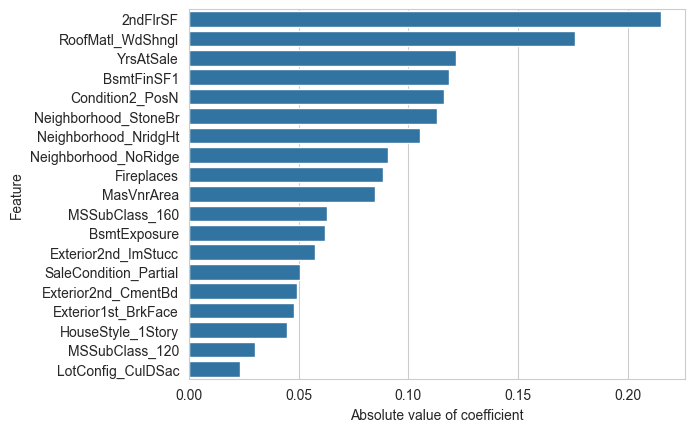

In [61]:
sns.barplot(data = coef_df, y = 'feature', x = 'abs_coef', orient = 'h');
plt.xlabel('Absolute value of coefficient');
plt.ylabel('Feature');

Based on this analysis, we can conclude that the top 5 features influencing the sale price are:
1. Area of second floor (2ndFlrSF)
2. Whether or not the roof is made of wood shingles (RoofMatl_WdShngl)
3. Age of the house in years at the time of sale (YrsAtSale)
4. Rating of finished area of a Type 1 basement (BsmtFinSF1)
5. Whether or not the house is near positive off-site feature park, green belt, etc. (Condition2_PosN)